In [4]:
# import python library for data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# display image
from IPython.display import Image

# stat on data
from scipy import stats
from scipy.stats import norm, skew 
import statsmodels.api as sm

# # import library for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

ModuleNotFoundError: No module named 'numpy'

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='background:#7ca4cd; border:0' role="tab" aria-controls="home"><center> AUSER AQUIFER</center></h3>

Here, we load the data for the Auser aquifer, set the date as index and have a look at the dataframe.

In [2]:
# load the data
df_Auser = pd.read_csv(r"../input/acea-water-prediction/Aquifer_Auser.csv")

# set date as index
df_Auser['Date'] = pd.to_datetime(df_Auser['Date'],format='%d/%m/%Y', errors='ignore')
df_Auser = df_Auser.set_index('Date')

# Show the first 2 rows
df_Auser.head(2)

,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,Rainfall_Fabbriche_di_Vallico,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
Date,,,,,,,,,,,,,,,,,,,,,
1998-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears to have a lot of missing values, so lets have a look at them.

> ## 1.1: Missing values
### 1.1.1: Verify the NAN values percentage and distribution:

In [3]:
def get_percentage_nan_values(data, thresh=20, color='black', edgecolor='black', width=15, height=3):
    """
    visualize the percentage of missing values in each columns
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh} missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

def show_distribution_nan_values(df):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
    sns.heatmap(df.T.isna(), cmap='Blues')
    ax.set_title('Fields with Missing Values', fontsize=16)
    #for tick in ax.xaxis.get_major_ticks():
    #    tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    return plt.show()

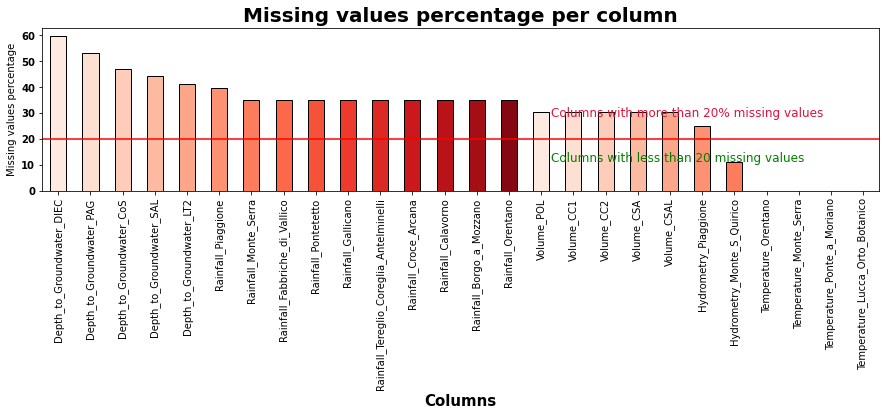

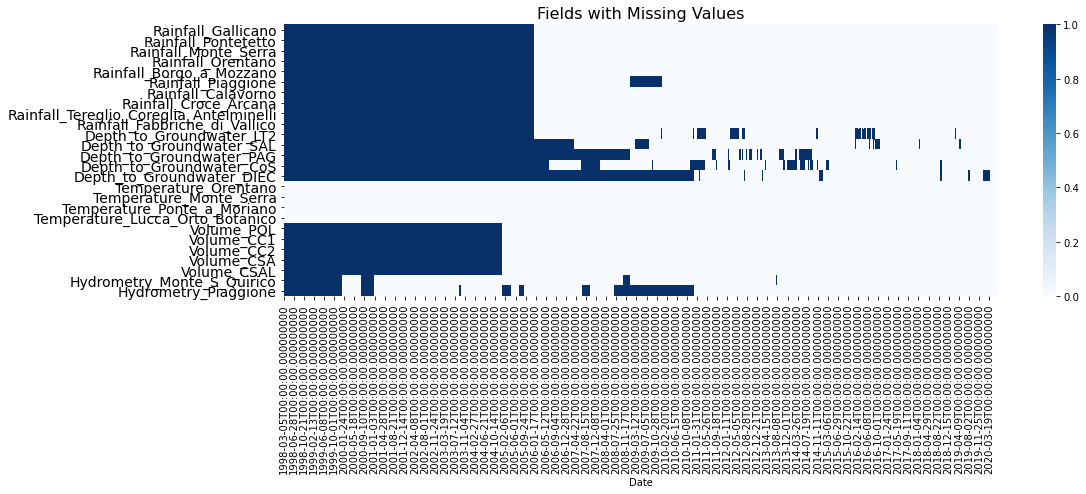

In [4]:
# show percentage and distribution missing values per columns
get_percentage_nan_values(df_Auser, 20, color=sns.color_palette('Reds',15))
show_distribution_nan_values(df_Auser)

Some columns contains a lot of missing data (between ~30 and ~60%), but fortunately these missing values seem to be located before 2006. So, I will select and work with the data obteined after 2006. 

### 1.1.2: Select an appropriate period to minimize the NAN values:

In [5]:
# select data after 2006-01-01
df_Auser = df_Auser[df_Auser.index >='2006-01-01']

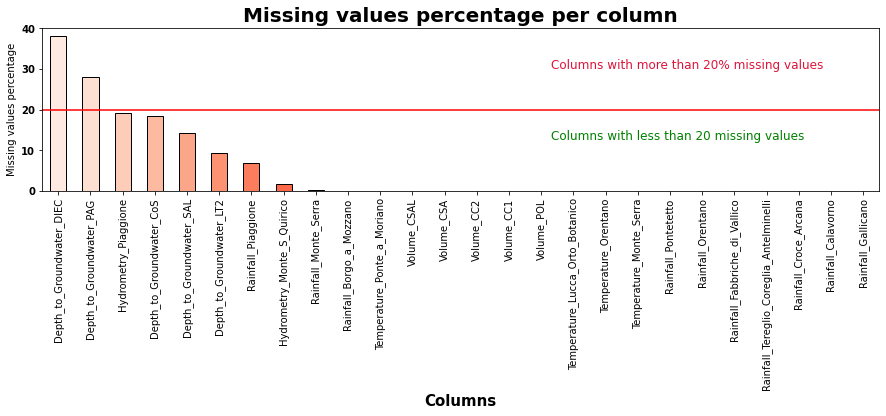

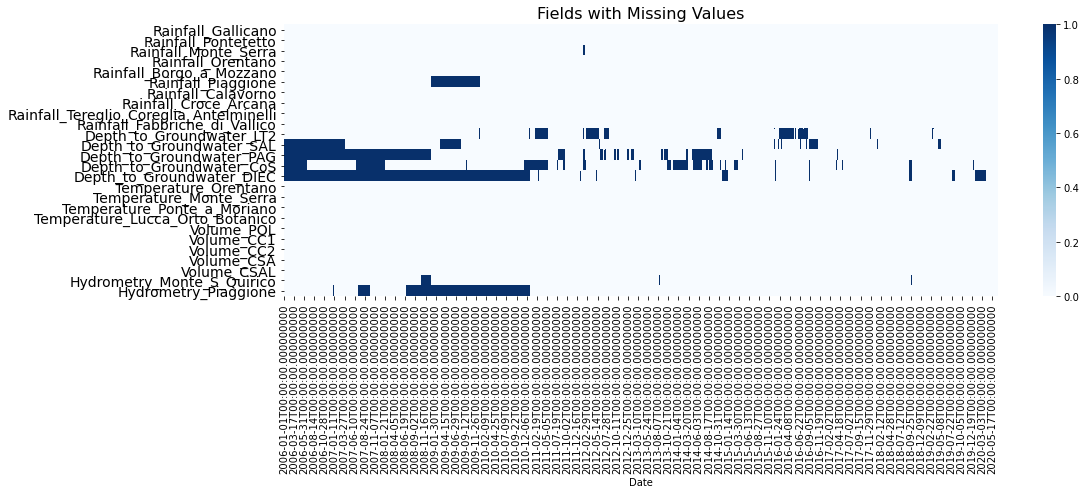

In [6]:
# look at the percentage and distribution of the missing value
get_percentage_nan_values(df_Auser, 20, color=sns.color_palette('Reds',15))
show_distribution_nan_values(df_Auser)

This is much better. Almost all the columns have less than 20% of missing values. 
Now, lets have a look at these data to better understand how we can deal with the nan values. 

## 1.1.3: How to process with the missing data
Now, we can plot the data to give us a better idea on the way to clean the data.

In [7]:
# get columns names
df_Auser.columns

Index(['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra',
       'Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana',
       'Rainfall_Tereglio_Coreglia_Antelminelli',
       'Rainfall_Fabbriche_di_Vallico', 'Depth_to_Groundwater_LT2',
       'Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG',
       'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC',
       'Temperature_Orentano', 'Temperature_Monte_Serra',
       'Temperature_Ponte_a_Moriano', 'Temperature_Lucca_Orto_Botanico',
       'Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL',
       'Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione'],
      dtype='object')

In [8]:
# create lists with same type of variables
Auser_rainfall=['Rainfall_Gallicano', 'Rainfall_Pontetetto', 'Rainfall_Monte_Serra','Rainfall_Orentano', 'Rainfall_Borgo_a_Mozzano', 'Rainfall_Piaggione',
       'Rainfall_Calavorno', 'Rainfall_Croce_Arcana','Rainfall_Tereglio_Coreglia_Antelminelli','Rainfall_Fabbriche_di_Vallico']
Auser_Groundwater=['Depth_to_Groundwater_LT2','Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_PAG','Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_DIEC']
Auser_Temperature=['Temperature_Orentano', 'Temperature_Monte_Serra','Temperature_Ponte_a_Moriano', 'Temperature_Lucca_Orto_Botanico']
Auser_Volume = ['Volume_POL', 'Volume_CC1', 'Volume_CC2', 'Volume_CSA', 'Volume_CSAL']
Auser_hydrometry=['Hydrometry_Monte_S_Quirico', 'Hydrometry_Piaggione']

####  Here, I added these lines after plotting 'Auser_Volume'.              ###   
####  We need to change the scale to logarithmic For data visualisation     ###
# change the scale to logarithmic
df_Auser['Volume_POL_log10'] = -np.log10(abs(df_Auser['Volume_POL']))
df_Auser['Volume_CC1_log10'] = -np.log10(abs(df_Auser['Volume_CC1']))
df_Auser['Volume_CC2_log10'] = -np.log10(abs(df_Auser['Volume_CC2']))
df_Auser['Volume_CSA_log10'] = -np.log10(abs(df_Auser['Volume_CSA']))
df_Auser['Volume_CSAL_log10'] = -np.log10(abs(df_Auser['Volume_CSAL']))

# create new list with columns names
Auser_Volume_log = ['Volume_POL_log10', 'Volume_CC1_log10', 'Volume_CC2_log10', 'Volume_CSA_log10', 'Volume_CSAL_log10']

# changing the scale may create infinite value so we replace 'inf' value by 'nan' values
df_Auser[Auser_Volume_log] = df_Auser[Auser_Volume_log].replace([np.inf, -np.inf], np.nan).fillna(0)


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# create function to plot the data per type of variables
def plot_data():
    # Separate columns into smaller dataframes to perform visualisations
    df_Auser_rainfall = df_Auser[Auser_rainfall]
    df_Auser_Groundwater = df_Auser[Auser_Groundwater]
    df_Auser_Temperature = df_Auser[Auser_Temperature]
    df_Auser_Volume_log = df_Auser[Auser_Volume_log]
    df_Auser_Volume = df_Auser[Auser_Volume]
    df_Auser_hydrometry = df_Auser[Auser_hydrometry]

    # plot data
    ax = df_Auser_rainfall.plot(figsize=(12, 4), fontsize=12,linewidth=2)
    ax.set_xlabel('Date', fontsize=16)
    ax.set_ylabel('mm', fontsize=16)
    ax.set_title('Auser Aquifer: Rainfall data', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax1 = df_Auser_Groundwater.plot(figsize=(12, 4), fontsize=12,linewidth=2)
    ax1.set_xlabel('Date', fontsize=16)
    ax1.set_ylabel('m', fontsize=16)
    ax1.set_title('Auser Aquifer: Groundwater Level data', fontsize=16)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax2 = df_Auser_Temperature.plot(figsize=(12, 4), fontsize=12,linewidth=2)
    ax2.set_xlabel('Date', fontsize=16)
    ax2.set_ylabel('C', fontsize=16)
    ax2.set_title('Auser Aquifer: Temperature data', fontsize=16)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax3 = df_Auser_Volume_log.plot(figsize=(12, 4), fontsize=12,linewidth=2,marker='o')
    ax3.set_xlabel('Date', fontsize=16)
    ax3.set_ylabel('m3', fontsize=16)
    ax3.set_title('Auser Aquifer: Volume data', fontsize=16)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax4 = df_Auser_hydrometry.plot(figsize=(12, 4), fontsize=12,linewidth=2)
    ax4.set_xlabel('Date', fontsize=16)
    ax4.set_ylabel('', fontsize=16)
    ax4.set_title('Auser Aquifer: Monthly hydrometry', fontsize=16)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

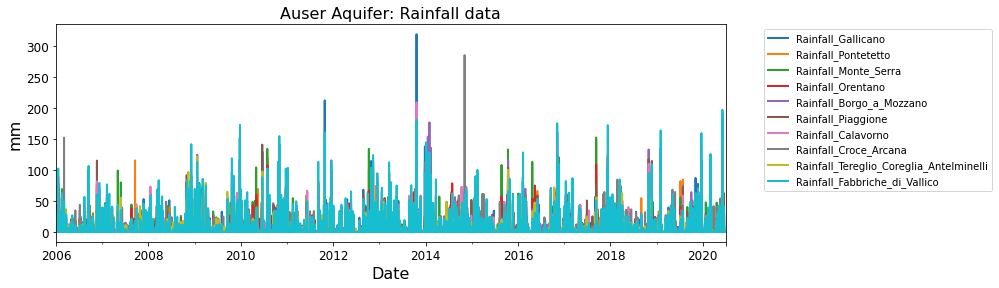

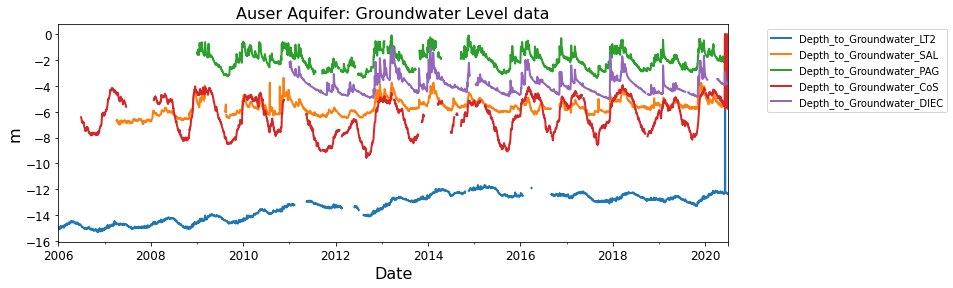

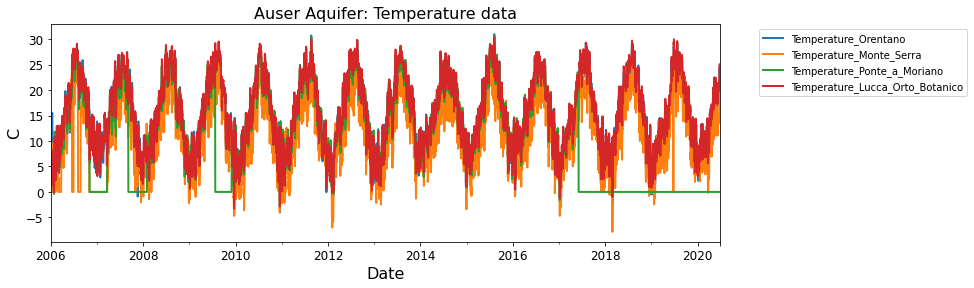

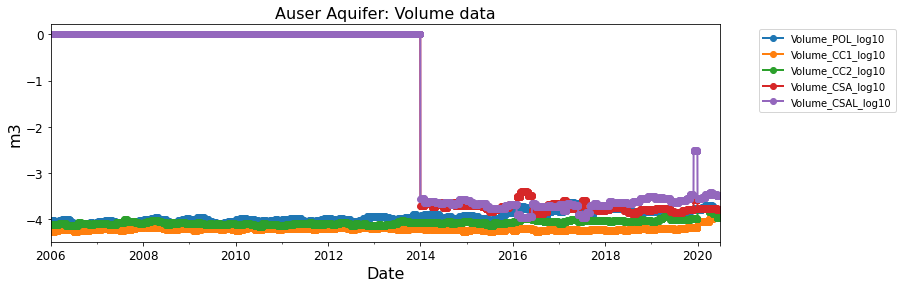

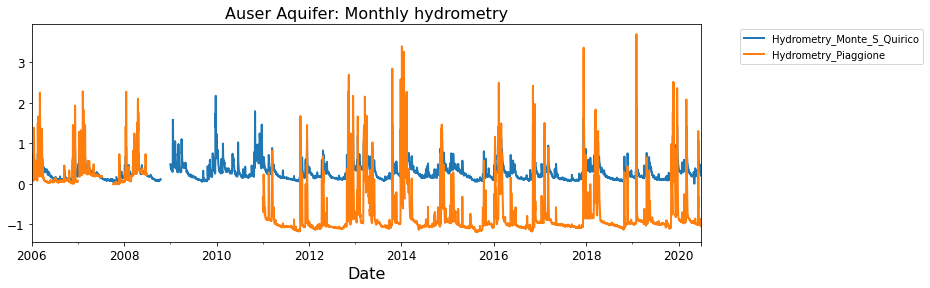

In [10]:
plot_data()

We can observe:
    - the rainfall data seems to be OK,
    - the goundwater level data have numerous missing data, and in 2020 several values are equal to zero. It is highly suspicious and these zero values may be considered as missing data.
    - the temperature data seems to be OK, expected the temperature monitored at 'Ponte a Moriano'. This one can be drop.
    - the volume data seems to be OK, expected in 2020. We won't use these data in the analyse.

### 1.1.4: remove missing data noted with 'zero' 
Waterlevel close to zero is highly suspicious. Here, we replace these value by the previous value.

In [11]:
# here we just make sure the suspicious values observed in the plot are really equal to zero.
print(df_Auser['Depth_to_Groundwater_LT2'].sort_values(ascending=False).head(5))
print(df_Auser['Depth_to_Groundwater_CoS'].sort_values(ascending=False).head(5))
print(df_Auser['Depth_to_Groundwater_SAL'].sort_values(ascending=False).head(6))

Date
2020-06-06     0.00
2020-06-07     0.00
2015-03-25   -11.66
2015-01-30   -11.68
2016-06-15   -11.72
Name: Depth_to_Groundwater_LT2, dtype: float64
Date
2020-06-07    0.00
2020-06-26    0.00
2020-06-05    0.00
2020-06-06    0.00
2018-03-20   -3.95
Name: Depth_to_Groundwater_CoS, dtype: float64
Date
2020-06-12    0.0
2020-06-16    0.0
2020-06-11    0.0
2020-06-07    0.0
2020-06-13    0.0
2020-06-26    0.0
Name: Depth_to_Groundwater_SAL, dtype: float64


In [12]:
# REPLACE missing value noted with '0' by the previous data
df_Auser['Depth_to_Groundwater_LT2'] = df_Auser['Depth_to_Groundwater_LT2'].replace(to_replace=0, method='ffill')
df_Auser['Depth_to_Groundwater_CoS'] = df_Auser['Depth_to_Groundwater_CoS'].replace(to_replace=0.00, method='ffill')
df_Auser['Depth_to_Groundwater_SAL'] = df_Auser['Depth_to_Groundwater_SAL'].replace(to_replace=0, method='ffill')
df_Auser['Depth_to_Groundwater_DIEC'] = df_Auser['Depth_to_Groundwater_DIEC'].replace(to_replace=0, method='ffill')

### 1.1.5: remove missing data noted with 'Nan' 
Here, a missing value is replaced by the mean of the month of the year. In the case where no data are available for a month during a year, then the missing value is replaced by the mean of the month calculated from 2006 to 2020.

In [13]:
# create two column with the month and the year
df_Auser['Month'] = pd.DatetimeIndex(df_Auser.index).month
df_Auser['Year'] = pd.DatetimeIndex(df_Auser.index).year

# replace nan value by the mean of the month of the year
df_Auser.fillna(df_Auser.groupby(['Month','Year']).transform('mean'), inplace=True)

# Then if missing value  still present:
# replace nan value by the mean of the month calculated over the entire dataframe
df_Auser.fillna(df_Auser.groupby(['Month']).transform('mean'), inplace=True)

### 1.1.6: remove suspicious data observed at the end 2019 on Volume_CSAL_LOG10

In [14]:

df_csal = df_Auser.loc[df_Auser['Volume_CSAL_log10']!=0]
value_to_remove = df_csal['Volume_CSAL_log10'].max()
df_Auser['Volume_CSAL_log10'] = df_Auser['Volume_CSAL_log10'].replace(to_replace=value_to_remove, method='ffill')

# Remove second suspicious point
df_csal = df_Auser.loc[df_Auser['Volume_CSAL_log10']!=0]
value_to_remove = df_csal['Volume_CSAL_log10'].max()
df_Auser['Volume_CSAL_log10'] = df_Auser['Volume_CSAL_log10'].replace(to_replace=value_to_remove, method='ffill')

### 1.1.7: remove suspicious data observed in 2020

In [15]:
# select the last 14 years only
df_Auser = df_Auser[df_Auser.index <='2020-01-01']

### 1.1.8: resample dataframe to work with monthly value

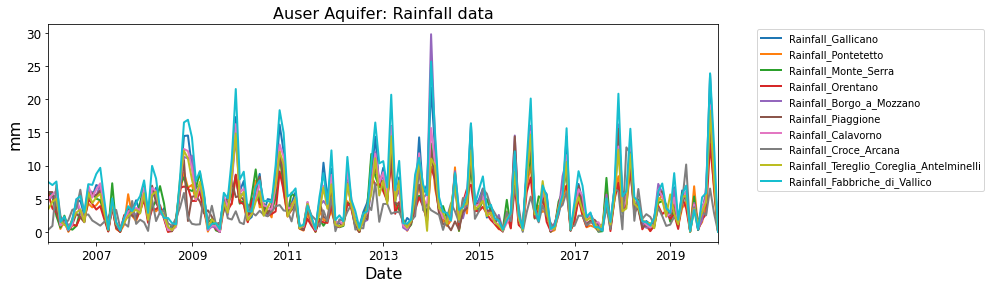

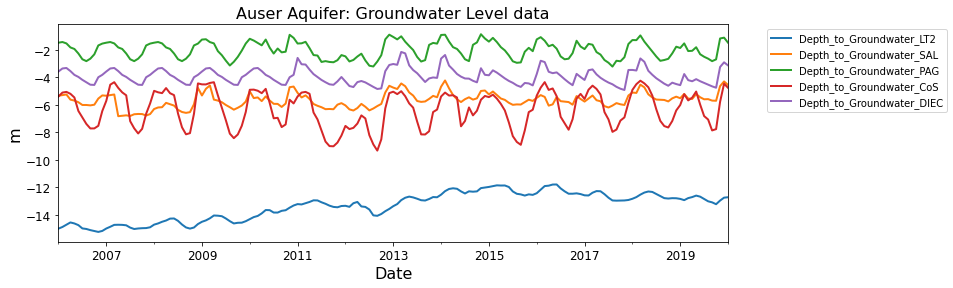

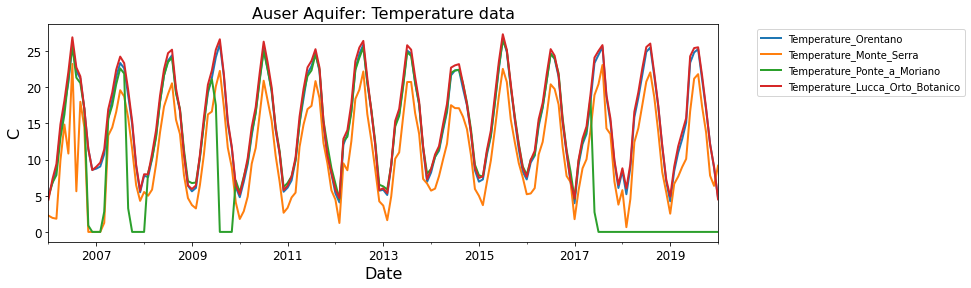

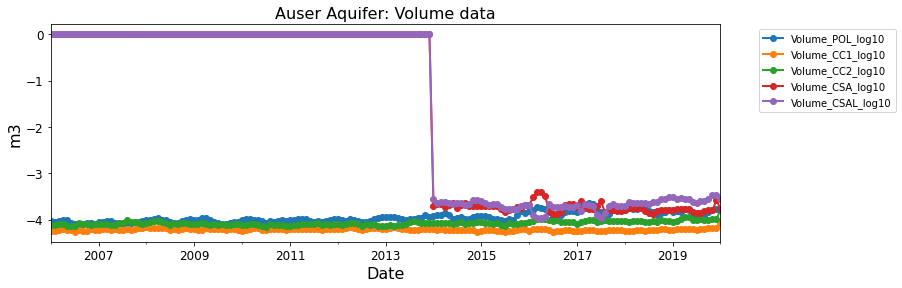

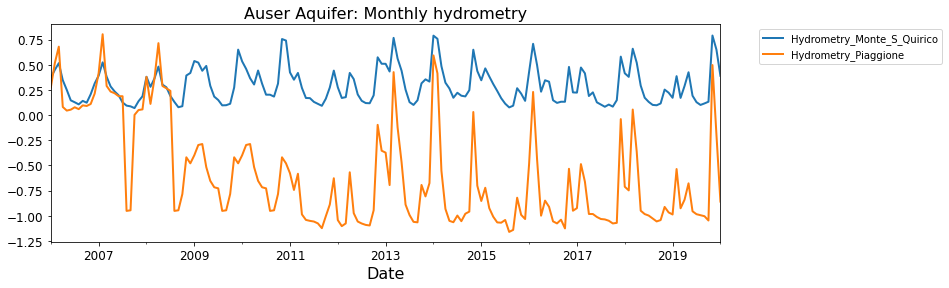

In [16]:
# resample for monthly value
df_Auser = df_Auser.resample('M').mean()

# see results
plot_data()

## 1.2: feature engineering

In [17]:
# calculate monthly mean temperature and mean rainfall
df_Auser['mean_temperature'] = df_Auser[['Temperature_Orentano', 'Temperature_Monte_Serra', 'Temperature_Lucca_Orto_Botanico']].mean(axis=1)
df_Auser['mean_rainfall']  = df_Auser[Auser_rainfall].mean(axis=1)

# calculate monthly total volume of pumping water
df_Auser['sum_volume_log']  = df_Auser[Auser_Volume_log].mean(axis=1)

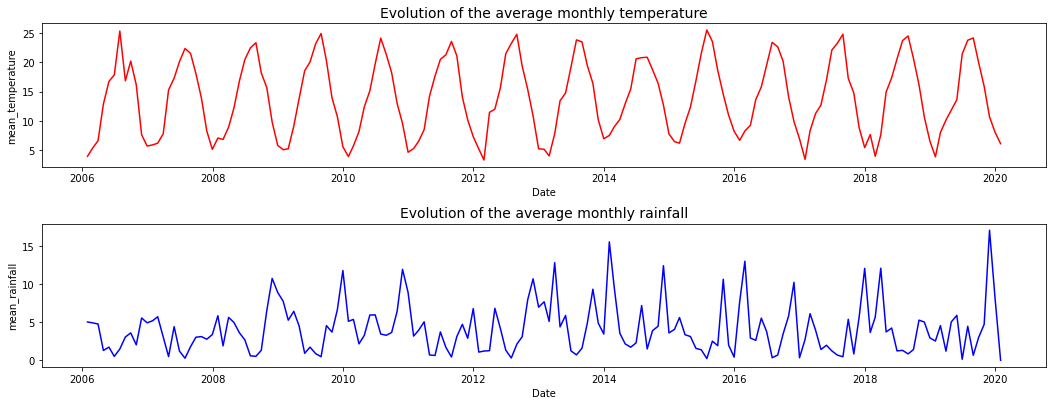

In [18]:
# plot mean temperature,mean rainfall, and water level
# define figure size and space between subplots
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# plot evolution of the average monthly temperature
ax1 = fig.add_subplot(3,1,1)
ax1 = sns.lineplot(x=df_Auser.index,y='mean_temperature',data=df_Auser,color='red')
ax1.set_title('Evolution of the average monthly temperature',size=14)

# plot evolution of the average monthly rainfall
ax2 = fig.add_subplot(3,1,2)
ax2 = sns.lineplot(x=df_Auser.index,y='mean_rainfall',data=df_Auser,color='blue')
ax2.set_title('Evolution of the average monthly rainfall',size=14)


plt.show()

#### calcule effective rainfall:
We know that a part of the rainfall is used by the vegetation, it is what is called the evapotranspiration (=EVP). So toconsider EVP, we made the following assumptiion. When the temperature is high all the rainfall is used by the vegetation
(EVP = 100%). Inversely, when the temperature is low, EVP is low (EVP = 0 %) and all the rainfall infiltrate into the 
ground

In [19]:
# calculate the percentage of evapotranspiration (range from 0 and 100%)
df_Auser.loc[:,'perct_evapo1'] = (df_Auser['mean_temperature']*100) / (df_Auser['mean_temperature'].max()
                                                                       -df_Auser['mean_temperature'].min())
df_Auser.loc[:,'perct_evapo']= df_Auser['perct_evapo1'] - df_Auser['perct_evapo1'].min()
df_Auser = df_Auser.drop(columns=['perct_evapo1'])

# calculate effective rainfall: rainfall minus evp
df_Auser.loc[:,'effective_rainfall'] = df_Auser['mean_rainfall'] -  \
                                       df_Auser['mean_rainfall']*df_Auser['perct_evapo']/100

We can compare the evolution of the monthly average rainfall with the monthly effective rainfall and with the evolution of the water table monitored in well SAL.

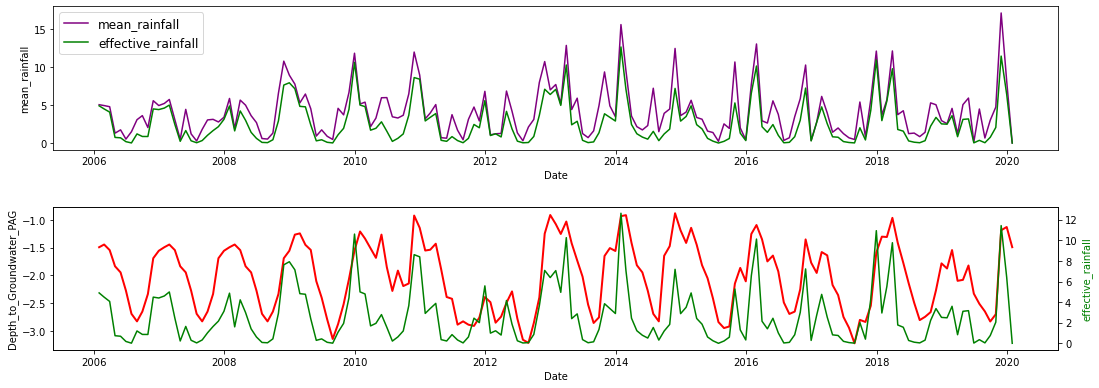

In [20]:
# Set figure size and space between subplt
fig = plt.figure(figsize=(18,10))
fig.subplots_adjust(hspace=0.4,wspace=0.3)

# Plot evolution of the 'mean_rainfall' and 'effective rainfall'
ax1 = fig.add_subplot(3,1,1)
ax1 = sns.lineplot(x=df_Auser.index,y='mean_rainfall',data=df_Auser,color='purple',label = 'mean_rainfall')
ax1 = sns.lineplot(x=df_Auser.index,y='effective_rainfall',data=df_Auser,color='green',label = 'effective_rainfall')
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(3,1,2)
ax2 = sns.lineplot(x=df_Auser.index,y='Depth_to_Groundwater_PAG',data=df_Auser,linewidth=2.0,color='red')
ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax3 = sns.lineplot(x=df_Auser.index,y='effective_rainfall',data=df_Auser,color='green')
ax3.set_ylabel('effective_rainfall', color='green')

# ax4 = fig.add_subplot(3,1,3)
# ax4 = sns.lineplot(x=df_Auser.index,y='effective_rainfall_diff_s1',data=df_Auser,linewidth=2.0,color='red')
# ax4 = sns.lineplot(x=df_Auser.index,y='effective_rainfall_diff_s2',data=df_Auser,linewidth=2.0,color='blue')
# ax4 = sns.lineplot(x=df_Auser.index,y='effective_rainfall_diff_s3',data=df_Auser,linewidth=2.0,color='purple')
# ax5 = ax4.twinx()  # instantiate a second axes that shares the same x-axis
# ax5 = sns.lineplot(x=df_Auser.index,y='Depth_to_Groundwater_LT2',data=df_Auser,color='green')
# ax5.set_ylabel('effective_rainfall', color='green')

plt.show()

The result looks quite good!

#### lag time due to infiltration:
Because infiltration can occurs very suddently along cracks and fractures on the ground and/on very slowly along micro-pores, we consider a period of four months during which the 'effective rainfall' may reached the aquifer.

In [21]:
df_Auser.loc[:,'Hydrometry_Monte_S_Quirico_s1'] = df_Auser['Hydrometry_Monte_S_Quirico'].shift(1)
df_Auser.loc[:,'Hydrometry_Piaggione_s1'] = df_Auser['Hydrometry_Piaggione'].shift(1)

df_Auser.loc[:,'Depth_to_Groundwater_PAG_s1'] = df_Auser['Depth_to_Groundwater_PAG'].shift(1)
df_Auser.loc[:,'Depth_to_Groundwater_DIEC_s1'] = df_Auser['Depth_to_Groundwater_DIEC'].shift(1)

# lag versions of the effective_rainfall
df_Auser.loc[:,'effective_rainfall_s1'] = df_Auser['effective_rainfall'].shift(1)
df_Auser.loc[:,'effective_rainfall_s2'] = df_Auser['effective_rainfall'].shift(2)
df_Auser.loc[:,'effective_rainfall_s3'] = df_Auser['effective_rainfall'].shift(3)
df_Auser.loc[:,'effective_rainfall_s4'] = df_Auser['effective_rainfall'].shift(4)


#### using futur monitoring data of the water level to predict the waterlevel???
It seems not correct to use the monitoring data of the groundwater level in one well to predict the groundaterwater level in another well for the same period. Just do the measure directly! On the otherhand, we can use the groundaterwater level monitored the month before. 
For these reasons we have created a lag version of 'Depth_to_Groundwater_PAG', 'Depth_to_Groundwater_DIEC, 'Hydrometry_Monte_S_Quirico' and 'Hydrometry_Piaggione'. 


In [22]:
df_Auser.loc[:,'Hydrometry_Monte_S_Quirico_s1'] = df_Auser['Hydrometry_Monte_S_Quirico'].shift(1)
df_Auser.loc[:,'Hydrometry_Piaggione_s1'] = df_Auser['Hydrometry_Piaggione'].shift(1)

df_Auser.loc[:,'Depth_to_Groundwater_PAG_s1'] = df_Auser['Depth_to_Groundwater_PAG'].shift(1)
df_Auser.loc[:,'Depth_to_Groundwater_DIEC_s1'] = df_Auser['Depth_to_Groundwater_DIEC'].shift(1)

df_Auser = df_Auser.dropna()

In [23]:
# # drop columns not needed anymore
df_Auser = df_Auser.drop(Auser_rainfall, axis=1)
df_Auser = df_Auser.drop(Auser_Temperature, axis=1)
df_Auser = df_Auser.drop(Auser_Volume, axis=1)
df_Auser = df_Auser.drop(Auser_hydrometry, axis=1)
df_Auser = df_Auser.drop(columns=['perct_evapo','mean_rainfall','mean_temperature','Month','Year',
                                  'Depth_to_Groundwater_PAG','Depth_to_Groundwater_DIEC'])
df_Auser.shape

(165, 18)

## 1.3: Machine learning
### 1.3.1: test for multicolinearity

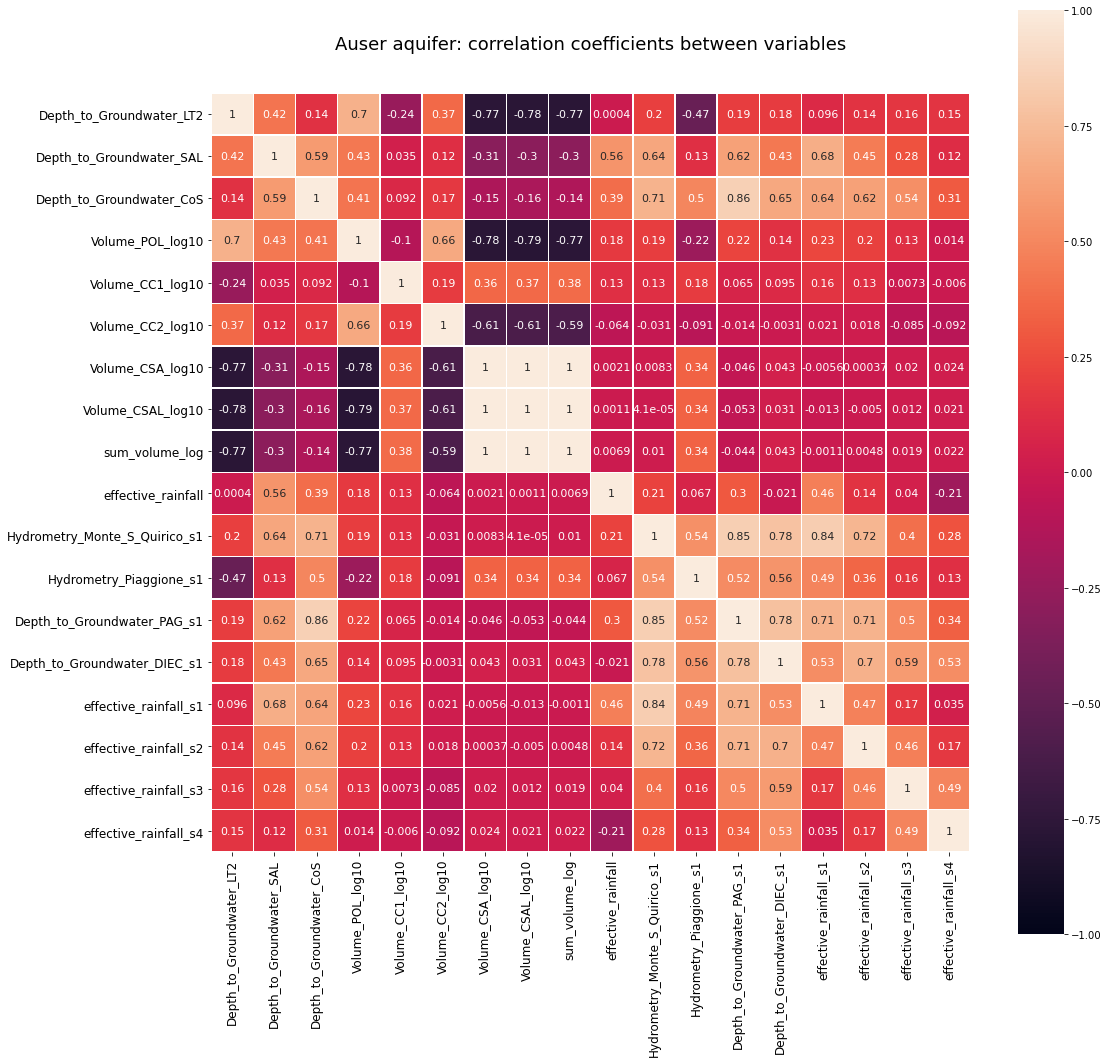

In [24]:
corr = df_Auser.corr(method='pearson')

fig, ax = plt.subplots(figsize=(17,17)) 

ax = sns.heatmap(corr,annot=True,linewidths=.5, annot_kws={"size": 11},vmin=-1.0, vmax=1.0,square=True,cbar=True)
ax.set_title('Auser aquifer: correlation coefficients between variables',size=18,y=1.05)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,size=12) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,size=12)
plt.show()

We can see the correlations between effective rainfall and groundwater levels are slihtly better than the correlation coefficients between mean rainfall and groundwater levels. 

### 1.3.2 slipt into a training and testing data set

In [25]:
# split the dataframe into a training and testing dataset
df_Auser_train = df_Auser[(df_Auser.index >='2005-01-01')&(df_Auser.index <'2017-01-01')]
df_Auser_test  = df_Auser[(df_Auser.index >='2017-01-01')]
#     df = df[df.index >='2003-01-01']
print("the shape of the dataframe for training is {} :".format(df_Auser_train.shape))
print("the shape of the dataframe for testing is {} :".format(df_Auser_test.shape))
print("the train dataframe contain {}% of the data :".format((df_Auser_train.shape[0]*100)/df_Auser.shape[0]))

the shape of the dataframe for training is (128, 18) :
the shape of the dataframe for testing is (37, 18) :
the train dataframe contain 77.57575757575758% of the data :


In [26]:
X_train_Auser = df_Auser_train.drop(columns=['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS',
                                            'Depth_to_Groundwater_LT2'],axis=1)
y_train_sal = df_Auser_train['Depth_to_Groundwater_SAL'].values
y_train_cos = df_Auser_train['Depth_to_Groundwater_CoS'].values
y_train_lt2 = df_Auser_train['Depth_to_Groundwater_LT2'].values

X_test_Auser = df_Auser_test.drop(columns=['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS',
                                            'Depth_to_Groundwater_LT2'],axis=1)
y_test_sal = df_Auser_test['Depth_to_Groundwater_SAL'].values
y_test_cos = df_Auser_test['Depth_to_Groundwater_CoS'].values
y_test_lt2 = df_Auser_test['Depth_to_Groundwater_LT2'].values


### 1.3.3: Scale the data
We use SdandartScaler to scale the data.

In [27]:
# from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
# transform "x_train"
X_train = scaler.fit_transform(X_train_Auser)
# transform "x_test"
X_test = scaler.transform(X_test_Auser)

### 1.3.4: evaluated the model

In [28]:
import math
def score(y_pred,y_test):
    return str(math.sqrt(mean_squared_error(y_test)))

def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

from statsmodels.graphics.api import abline_plot
def model_evaluation(prediction,y_test):
    r2 = round(metrics.r2_score(y_test, prediction), 2)
    abs_perc_error = np.mean(np.abs((y_test-prediction)/prediction))
    mean_abs_err = metrics.mean_absolute_error(y_test, prediction)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
    print("R2 (explained variance):",r2 )
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", abs_perc_error)
    print("Mean Absolute Error (Σ|y-pred|/n):", "{:,f}".format(mean_abs_err))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,f}".format(rmse))
    ## residuals
#     prediction = prediction.reshape(len(prediction),1)
    residuals = y_test - prediction
    if abs(max(residuals)) > abs(min(residuals)):
        max_error = max(residuals)  
    else:
        max_error = min(residuals) 
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
    # max_true = y_test[max_idx]
    max_pred = prediction[max_idx]
    print("Max Error:", "{}".format(max_error))
    
    ## Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
    ax[0].scatter(prediction, y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    # ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error, color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    ## Plot predicted vs residuals
    ax[1].scatter(prediction, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black', linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(prediction), xmax=np.max(prediction))
    ax[1].legend()
    plt.show()
    
    print('The model explains {}% of the variance of the target variable.'.format(r2*100))
    print('On average, predictions have an error of {:,.2f}, or they’re wrong by {:,.2f}%.'.format(mean_abs_err,(abs_perc_error)*100)) 
    print('The biggest error on the test set was over {:,.2f}.'.format(rmse))


### 1.3.5: Predict 'Depth_to_Groundwater_SAL'
### 1.5.5.1: Linear regression
#### Feature selection



In [29]:
X_train2 = pd.DataFrame(X_train)
X_train2.columns =[X_train_Auser.columns]

#Backward Elimination
cols = ['Volume_POL_log10', 'Volume_CC1_log10', 'Volume_CC2_log10',
       'Volume_CSA_log10', 'Volume_CSAL_log10', 'sum_volume_log',
       'effective_rainfall', 'effective_rainfall_s1', 'effective_rainfall_s2',
       'effective_rainfall_s3', 'effective_rainfall_s4',
       'Hydrometry_Monte_S_Quirico_s1', 'Hydrometry_Piaggione_s1',
       'Depth_to_Groundwater_PAG_s1', 'Depth_to_Groundwater_DIEC_s1']
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train2[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train_sal,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)


['Volume_POL_log10', 'Volume_CC1_log10', 'Volume_CC2_log10', 'Volume_CSA_log10', 'Volume_CSAL_log10', 'effective_rainfall', 'effective_rainfall_s2', 'Hydrometry_Monte_S_Quirico_s1', 'Hydrometry_Piaggione_s1', 'Depth_to_Groundwater_DIEC_s1']


In [30]:
X_train_sal_lr = X_train_Auser[selected_features_BE]
X_test_sal_lr = X_test_Auser[selected_features_BE]
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=12, verbose=1 , scoring = 'neg_mean_squared_error')
grid_linear.fit(X_train_sal_lr, y_train_sal)

sc_linear = get_best_score(grid_linear)

Fitting 12 folds for each of 8 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.3656058510473228
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(normalize=True)


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.5s finished


#### Best fit

R2 (explained variance): 0.62
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.04516578161522602
Mean Absolute Error (Σ|y-pred|/n): 0.234544
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.274123
Max Error: -0.6845051029734375


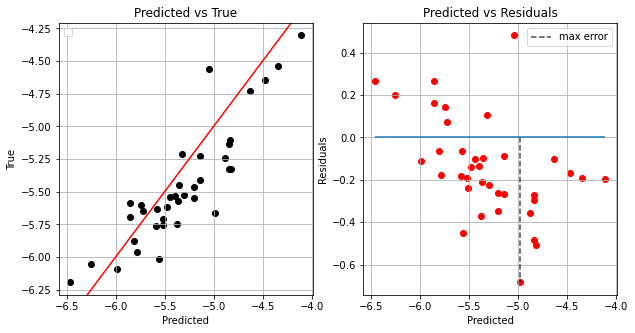

The model explains 62.0% of the variance of the target variable.
On average, predictions have an error of 0.23, or they’re wrong by 4.52%.
The biggest error on the test set was over 0.27.


In [31]:
## call model 1 with all the variables
model_LinReg = linear_model.LinearRegression(copy_X= True, fit_intercept= False, normalize= True)
model_LinReg.fit(X_train_sal_lr, y_train_sal)
prediction = model_LinReg.predict(X_test_sal_lr)
model_evaluation(prediction,y_test_sal)

### 1.3.6: Predict 'Depth_to_Groundwater_CoS'

In [32]:
## Importing Ridge. 
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha':[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.1,0.5,0.7,1], 
              'tol':[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]}
grid_ridge = GridSearchCV(ridge, parameters, cv=12, verbose=1, scoring = 'neg_mean_squared_error')
grid_ridge.fit(X_train, y_train_cos)

sc_ridge = get_best_score(grid_ridge)

Fitting 12 folds for each of 108 candidates, totalling 1296 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6183018229840277
{'alpha': 1, 'tol': 1e-09}
Ridge(alpha=1, tol=1e-09)


[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed:    1.7s finished


R2 (explained variance): 0.92
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.048213865110154235
Mean Absolute Error (Σ|y-pred|/n): 0.271595
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.324449
Max Error: 0.6298743886066136


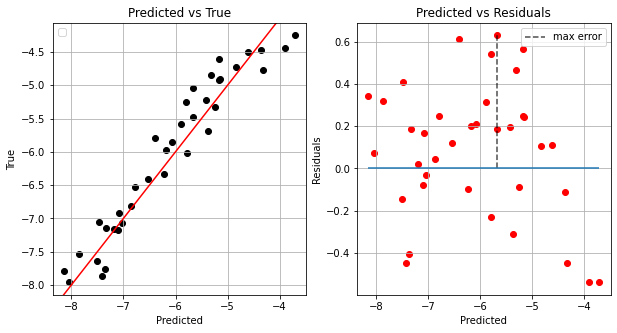

The model explains 92.0% of the variance of the target variable.
On average, predictions have an error of 0.27, or they’re wrong by 4.82%.
The biggest error on the test set was over 0.32.


In [33]:
## best fit: 
ridge_bf = Ridge(alpha= 1, normalize=False,tol = 1e-9)
## fit the model. 
ridge_bf.fit(X_train, y_train_cos)
## Predicting the target value based on "Test_x"
y_pred = ridge_bf.predict(X_test)

model_evaluation(y_pred,y_test_cos)